### Name: Riya Shyam Huddar
### Roll number: MDS202431
### Applied Machine Learning - Assignment 1

### Dataset Overview
We use the **SMS Spam Collection Dataset** from the UCI Machine Learning Repository.  
The dataset consists of SMS messages labeled as either **spam** or **ham** (non-spam).

- **Number of instances**: 5,574 SMS messages  
- **Classes**:
  - `ham`: legitimate messages  
  - `spam`: unsolicited or promotional messages  
- **Task**: Binary text classification

In [74]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

### 1. Load SMS Spam Dataset

The SMS Spam Collection dataset is loaded from the local file system.
The dataset contains two columns:
- `label`: ham (0) or spam (1)
- `text`: raw SMS message content


In [76]:
# load data from local filepath
def load_data(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # split only on the first tab
            if "\t" in line:
                label, text = line.split("\t", 1)
                data.append([label, text])
    df = pd.DataFrame(data, columns=["label", "text"])
    return df

DATA_PATH = r"D:\CMI\AppliedML\Assignment 1\sms+spam+collection\SMSSpamCollection"
df = load_data(DATA_PATH)
print("Total rows loaded:", len(df))
df.head()


Total rows loaded: 5574


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 2. Exploratory Data Analysis

### Class Distribution Summary

The dataset contains **5,574 SMS messages** with two classes:
- **Ham**: 4,827 messages (~86.6%)
- **Spam**: 747 messages (~13.4%)

This indicates a **class imbalance**, with ham messages forming the majority of the data. As a result, accuracy alone may be misleading, and metrics such as precision, recall, and F1-score are more appropriate for evaluating model performance.


In [78]:
print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["label"].value_counts())
print("\nClass distribution (percentage):")
print(df["label"].value_counts(normalize=True) * 100)


Dataset shape: (5574, 2)

Class distribution:
label
ham     4827
spam     747
Name: count, dtype: int64

Class distribution (percentage):
label
ham     86.598493
spam    13.401507
Name: proportion, dtype: float64


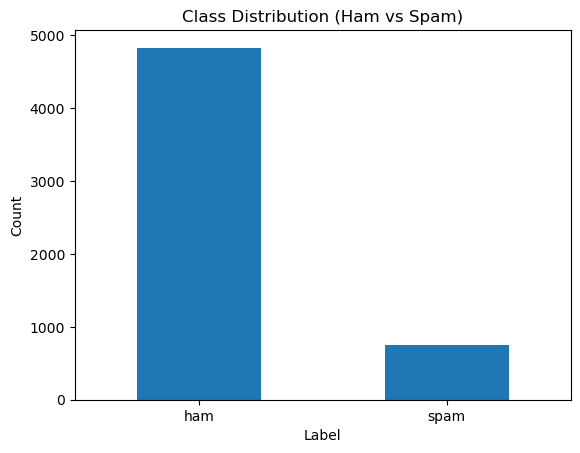

In [80]:
df["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution (Ham vs Spam)")
plt.xticks(rotation=0)
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Word Cloud Visualization (Ham vs Spam)

To qualitatively compare the vocabulary used in ham and spam messages, we generate separate word clouds for each class. All messages within a class are concatenated into a single corpus, and the most frequent words are visualized using word clouds. This provides an intuitive view of class-specific language patterns and highlights commonly used terms in spam versus non-spam messages.


In [82]:
ham_text = " ".join(df[df["label"] == "ham"]["text"])
spam_text = " ".join(df[df["label"] == "spam"]["text"])

In [84]:
ham_wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords="english"
).generate(ham_text)

spam_wc = WordCloud(
    width=800,
    height=400,
    background_color="black",
    stopwords="english"
).generate(spam_text)


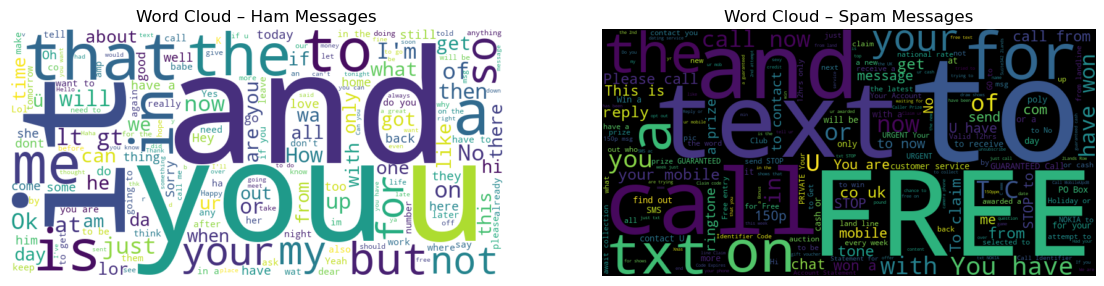

In [85]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(ham_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Ham Messages")

plt.subplot(1, 2, 2)
plt.imshow(spam_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Spam Messages")

plt.show()


No missing values were observed in either the labels or message text.

In [88]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [90]:
# Inspect a few sample messages from each class
print("Sample Ham Messages:\n")
for msg in df[df["label"] == "ham"]["text"].sample(3):
    print("-", msg)

print("\nSample Spam Messages:\n")
for msg in df[df["label"] == "spam"]["text"].sample(3):
    print("-", msg)


Sample Ham Messages:

- Not yet. Just i'd like to keep in touch and it will be the easiest way to do that from barcelona. By the way how ru and how is the house?
- Headin towards busetop
- If u laugh really loud.. If u talk spontaneously.. If u dont care what others feel.. U are probably with your dear &amp; best friends.. GOODEVENING Dear..:)

Sample Spam Messages:

- Todays Voda numbers ending 7548 are selected to receive a $350 award. If you have a match please call 08712300220 quoting claim code 4041 standard rates app
- Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matches call 09064019014 to receive your £350 award.
- U can WIN £100 of Music Gift Vouchers every week starting NOW Txt the word DRAW to 87066 TsCs www.ldew.com SkillGame,1Winaweek, age16.150ppermessSubscription


### Message Length Statistics by Class

Spam messages are significantly longer than ham messages on average.

- **Ham messages** have a median length of 52 characters and show high variability, ranging from very short personal messages to longer conversational texts.
- **Spam messages** have a much higher median length of 149 characters and are more tightly distributed, reflecting structured promotional or advertisement-style content.

In [92]:
df["message_length"] = df["text"].apply(len)
df.groupby("label")["message_length"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4827.0,71.440025,58.322011,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.634538,28.854103,13.0,133.0,149.0,157.0,223.0


Spam messages contain more words on average than ham messages, further supporting the observed length-based differences.

In [94]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
df.groupby("label")["word_count"].mean()

label
ham     14.304123
spam    23.911647
Name: word_count, dtype: float64

Some duplicate messages are present in the dataset. These are retained to reflect real-world message frequency patterns.

In [96]:
df.duplicated().sum()

414

-----

###  3. Data Preprocessing 

To prepare the SMS messages for classification, we applied the following preprocessing steps:

1. **Lowercasing**  
   - All text was converted to lowercase to treat words like `FREE` and `free` equivalently.

2. **Selective punctuation cleaning**  
   - Removed unnecessary punctuation such as `. , : ; -`  
   - Retained punctuation and symbols indicative of spam (`!`, `?`, `$`), as well as numbers and URLs, which are often strong spam signals.

3. **Label encoding**  
   - Converted `ham` to 0 and `spam` to 1.

In [98]:
import re

def preprocess_text(text):
    """
    Preprocess SMS text for spam classification.
    
    Steps:
    1. Lowercase all text
    2. Remove unnecessary punctuation (keep !, ?, $, numbers, URLs)
    3. Retain stopwords and original word forms (no stemming/lemmatization)
    """
    # Lowercase
    text = text.lower()
    
    # Remove URLs but keep the word "url" as a placeholder
    text = re.sub(r"http\S+|www\S+|https\S+", " url ", text)
    
    # Remove unnecessary punctuation except !, ?, $, numbers
    # Keep letters, numbers, spaces, ! ? $
    text = re.sub(r"[^a-z0-9!?$ ]", " ", text)
    
    # Collapse multiple spaces to one
    text = re.sub(r"\s+", " ", text).strip()
    
    return text


In [100]:
# Apply preprocessing to all SMS messages
df["cleaned_text"] = df["text"].apply(preprocess_text)

# Quick check
df[["text", "cleaned_text", "label"]].head(5)


,text,cleaned_text,label
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,ham
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,spam
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,ham
4,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives arou...,ham


In [102]:
# Label encoding
df["label_encoded"] = df["label"].map({"ham": 0, "spam": 1})

# Quick check
df[["label", "label_encoded"]].value_counts()


label  label_encoded
ham    0                4827
spam   1                 747
Name: count, dtype: int64

### Remove empty messages
We remove rows where `cleaned_text` is empty or only whitespace.

In [104]:
# Remove empty or whitespace-only cleaned_text
df = df[df["cleaned_text"].str.strip() != ""]

print("After removing empty messages:", df.shape)


After removing empty messages: (5572, 6)


----

### 4. Train, Validation, and Test Split

The dataset is split into:
- 70% training data
- 15% validation data
- 15% test data

Stratified sampling is used to preserve the spam/ham class distribution.


In [109]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
def split_data(df, train_size=0.7, val_size=0.15, random_state=42):
    """
    Splits the dataframe into train, validation, and test sets using stratification on label_encoded.
    
    Parameters:
    - df: dataframe
    - train_size: fraction for training set
    - val_size: fraction for validation set (test_size = 1 - train_size - val_size)
    - random_state: seed for reproducibility
    
    Returns:
    - train_df, val_df, test_df
    """
    # Split into train + temp (val + test)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        stratify=df["label_encoded"],
        random_state=random_state
    )
    
    # Compute relative size for validation within temp
    val_ratio = val_size / (1 - train_size)
    
    # Split temp into validation and test
    val_df, test_df = train_test_split(
        temp_df,
        train_size=val_ratio,
        stratify=temp_df["label_encoded"],
        random_state=random_state
    )
    
    return train_df, val_df, test_df


# Columns we actually want for modeling
feature_cols = ["cleaned_text","label_encoded", "label"]

# Filter dataframe
df_model = df[feature_cols]

# Apply split
train_df, val_df, test_df = split_data(df_model)

# Sanity check
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# Check class proportions
print("\nTrain class distribution:\n", train_df["label"].value_counts(normalize=True))
print("\nValidation class distribution:\n", val_df["label"].value_counts(normalize=True))
print("\nTest class distribution:\n", test_df["label"].value_counts(normalize=True))


Train size: 3900
Validation size: 835
Test size: 837

Train class distribution:
 label
ham     0.865897
spam    0.134103
Name: proportion, dtype: float64

Validation class distribution:
 label
ham     0.865868
spam    0.134132
Name: proportion, dtype: float64

Test class distribution:
 label
ham     0.866189
spam    0.133811
Name: proportion, dtype: float64


### Save Processed Datasets
The train, validation, and test splits are saved as CSV files.
These files will be used by the training notebook.

In [111]:
OUTPUT_DIR = r"D:\CMI\AppliedML\Assignment 1\data\processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df.to_csv(os.path.join(OUTPUT_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, "validation.csv"), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, "test.csv"), index=False)

print("Saved files:")
print(os.listdir(OUTPUT_DIR))


Saved files:
['test.csv', 'train.csv', 'validation.csv']
